# Lab 1: Neural Networks from Scratch

In this lab, we will implement simple neural networks in Python using only the `numpy` library (and `matplotlib` for visualization). The objective is to gain a strong intuition about how neural networks work. We will visualize the data space and the learning curve, and we'll animate these over the learning process, experimenting with different parameters.

Make sure you have the following libraries installed:

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import animation, rc
from IPython.display import HTML


In [2]:
# This cell allows you to connect to a tracker that sends results to a dedicated session visible by your professor.
# Only the professor has access to it. The goal is simply to follow the class work, not to track individual students.
# No records are made.

print('\n\n(If this cell runs for more than 30 seconds, stop it and rerun it.) \n\n')


import requests
exec(requests.get("https://raw.githubusercontent.com/claireBoyer/tutorial-conformal-prediction/main/labs/aux-npt/get-send-code.html").content)


# Replace 'TO_UPDATE' with the appropriate session information
npt_config = {'session_name': 'Lab1-Map545',}


# Prompt for the sender's name
npt_config['sender_name'] = input("Enter your name: \n -->")
npt_config['session_owner'] = input("\n \n Your teacher: depending on your teacher, enter either \n - ataylor \n - pascalbianchi \n - constantin.philippenko \n - renaud.gaucher \n-->") #  

print('\n \n You should get as an output <Response [200]> below. If not, you probably have a typo in the teacher name, retry :)')

send('started', 0)





(If this cell runs for more than 30 seconds, stop it and rerun it.) 


Enter your name: 
 -->

 
 Your teacher: depending on your teacher, enter either 
 - ataylor 
 - pascalbianchi 
 - constantin.philippenko 
 - renaud.gaucher 
-->

 
 You should get as an output <Response [200]> below. If not, you probably have a typo in the teacher name, retry :)


<Response [500]>

## Table of contents


[1. The data](#data)<br>

[2. Very simple models](#Very_simple_models)<br>
- [2.1 A very simple Neural Network](#Very_simple_nn)<br>
- [2.2 Perceptron](#Perceptron)<br>
- [2.3 Logistic regression](#Logistic_regression)<br>
- [2.4 Another data set](#Another_data_set)<br>

[3. A more complex neural network](#More_complicated_nn)<br>

[4. Bonus](#Bonus)<br>






<a id='data'></a>

## 1 - The data

First, we create a toy problem to work with. Write a function to generate synthetic 2D 2-class data (i.e., $\mathbf{x} \in \mathbb{R}^2$ and $y \in \{-1,1\}$) such that:
- $500$ observations are labelled $-1$ and $500$ observations are labelled $1$
- The observations from the class $-1$ are distributed as $\mathcal{N}(\mu_{-1}, \Sigma_{-1})$
- The observations from the class $1$ are distributed as $\mathcal{N}(\mu_{1}, \Sigma_{1})$

where $\mu_{-1} = (0,0)$, $\mu_1 = (2,2)$ and $
\Sigma_{-1} = \Sigma_{1} = \begin{pmatrix}
1 & 0 \\
0 & 1 \\
\end{pmatrix}.
$

**Using the following code, generate this data set and plot the result (e.g., an $x_1$ by $x_2$ scatter plot, where each class is coded by a different color).**

<Response [400]>

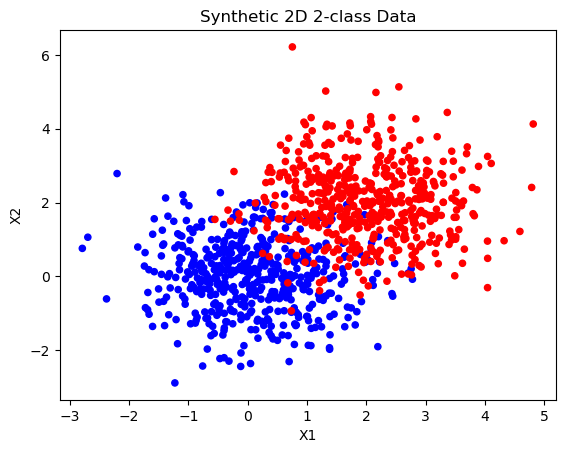

In [3]:
# Define parameters
mu0 = [0, 0]
mu1 = [2, 2]
Sigma0 = np.array([[1, 0], [0, 1]])
Sigma1 = np.array([[1, 0], [0, 1]])
np.random.seed(4)

def create_dataset(nb_datapoints=1000, prop_class=0.5, Sigma0=Sigma0, Sigma1=Sigma1, mu0=mu0, mu1=mu1):
    """
    Create a synthetic dataset with specified parameters.

    Parameters:
    - nb_datapoints: Total number of data points.
    - prop_class: Proportion of class 0 in the dataset.
    - Sigma0: Covariance matrix for class 0.
    - Sigma1: Covariance matrix for class 1.
    - mu0: Mean for class 0.
    - mu1: Mean for class 1.

    Returns:
    - df: Pandas DataFrame containing the dataset with columns "X1", "X2", and "Y".
    """
    data_size = int(np.floor(nb_datapoints * prop_class))

    X0 = np.random.multivariate_normal(mean=mu0, cov=Sigma0, size=data_size)
    X1 = np.random.multivariate_normal(mean=mu1, cov=Sigma1, size=nb_datapoints - data_size)

    dataset0 = np.concatenate((X0, np.repeat(-1, data_size).reshape(data_size, 1)), axis=1)
    dataset1 = np.concatenate((X1, np.repeat(1, nb_datapoints - data_size).reshape(nb_datapoints - data_size, 1)), axis=1)
    dataset = np.concatenate((dataset0, dataset1), axis=0)

    df = pd.DataFrame(dataset, columns=["X1", "X2", "Y"])
    return df

# Create a dataset and plot it
df = create_dataset()
colors = np.where(df["Y"] == 1, 'red', 'blue')
df.plot.scatter("X1", "X2", c=colors)
plt.title('Synthetic 2D 2-class Data')
plt.xlabel('X1')
plt.ylabel('X2')

send(plt, 1)


<a id='Very_simple_models'></a>


## 2 - Very simple models

<a id='Very_simple_nn'></a>

### 2.1 - A very simple neural network

#### 2.1.1 - Model definition

We will next implement a neural network with no hidden layer, with the sigmoid function as output function. We will consider the negative log-likelihood as the loss function and will solve the optimization problem with stochastic gradient descent (SGD). Recall that the sigmoid function $\sigma$ is defined as

$$
\sigma(t) = \frac{1}{1+e^{-t}}.
$$

Let $\mathbf{w}, b$ be respectively the weights and the bias of the output layer. Recall that the probability output by the neural network is given by

$$
\hat{\mathbb{P}}[Y=1 |\mathbf{X} = \mathbf{x}] = \sigma(\mathbf{w}^\top\mathbf{x}+b).
$$

##### Remark
We also have
$$
\hat{\mathbb{P}}[Y=-1 |\mathbf{X} = \mathbf{x}] = 1 - \sigma(\mathbf{w}^\top\mathbf{x}+b) = \sigma(- (\mathbf{w}^\top\mathbf{x}+b)).
$$
Consequently, for all $y \in \{-1,1\}$, we have
$$
\hat{\mathbb{P}}[Y=y |\mathbf{X} = \mathbf{x}] = \sigma(y (\mathbf{w}^\top\mathbf{x}+b)).
$$

##### Notations
A simpler way to write this equation is to change slightly the input and the weight vector, in order to take into account the bias $b$. You can do so by adding a component equal to $1$ at the end of $\mathbf{x}$ that is considering
$$
\tilde{\mathbf{x}} = (\mathbf{x}, 1),
$$
and similarly, with the weight vector
$$
\tilde{\mathbf{w}} = (\mathbf{w}, b).
$$
Notice that, in this case, we have
$$
\mathbf{w}^\top\mathbf{x}+b = \tilde{\mathbf{w}}^\top \tilde{\mathbf{x}}
$$
In this way, the output of the neural network can be written as
$$
\hat{\mathbb{P}}[Y=1 |\tilde{\mathbf{X}} = \tilde{\mathbf{x}}] = \sigma(\tilde{\mathbf{w}}^\top \tilde{\mathbf{x}}).
$$
Note that you can add a column of ones at the end of the matrix $\textbf{X}$, to obtain the matrix $\tilde{\textbf{X}}$, instead of adding a component $1$ to each input vector $\textbf{X}_i$.


**1) Prove that the negative log likelihood of the model is defined as
$$
\ell(\tilde{\mathbf{w}}, \mathcal{D}_n) = \frac{1}{n} \sum_{i=1}^n \log (1 + \exp(- y_i (\tilde{\mathbf{w}}^\top\tilde{\mathbf{x}}_i) ))
$$
and that its gradient is given by
$$
\nabla \ell(\tilde{\mathbf{w}}, \mathcal{D}_n) = - \frac{1}{n} \sum_{i=1}^n \alpha_i \tilde{\mathbf{x}}_i,
$$**
where $\alpha_i \in \mathbb{R}$ satisfies
$$
\alpha_i = \frac{y_i }{1 + \exp( y_i (\tilde{\mathbf{w}}^\top \tilde{\mathbf{x}}_i) )}.
$$

**2) Using Python, write the corresponding functions: the negative log-likelihood, the gradient of the negative log-likelihood, the percentage of incorrect classification, i.e. $1 - accuracy$. These functions take as input the weight vector $\tilde{\mathbf{w}} = (\mathbf{w}, b)$ and the data set (which is a matrix of size $n \times (d+1)$, where $d=2$).**

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def negative_log_likelihood_logistic(weights, dataset):
    """
    Compute the negative log-likelihood for logistic regression.

    Parameters:
    - weights: Vector of weights.
    - dataset: Pandas DataFrame containing the dataset with columns "X1", "X2", and "Y".

    Returns:
    Negative log-likelihood value.
    """
    y = dataset.iloc[:, -1]
    X = dataset.drop(dataset.columns[-1], axis=1)
    Xtilde = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    wtilde = weights
    
    # Compute the linear combination of weights and features
    z = np.dot(Xtilde, wtilde)*y

    loss = np.mean(np.log(1+np.exp(-z)))
    
    return loss 

send(negative_log_likelihood_logistic, 2)

def gradient_NLL_logistic(weights, dataset):
    """
    Compute the gradient of the negative log-likelihood for logistic regression.

    Parameters:
    - weights: Vector of weights.
    - dataset: Pandas DataFrame containing the dataset with columns "X1", "X2", and "Y".

    Returns:
    Vector representing the gradient.
    """
    y = dataset.iloc[:, -1]
    X = dataset.drop(dataset.columns[-1], axis=1)
    Xtilde = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    wtilde = weights
    
    
    # Compute the linear combination of weights and features
    z = np.dot(Xtilde, wtilde)*y

    alpha = y / (1+np.exp(z))
    
    gradient = -(1/dataset.shape[0]) * ( np.dot(alpha, Xtilde )   )
    return gradient


send(gradient_NLL_logistic, 3)

def error(weights, dataset):
    """
    Compute the classification error.

    Parameters:
    - weights: Vector of weights.
    - dataset: Pandas DataFrame containing the dataset with columns "X1", "X2", and "Y".

    Returns:
    Percentage of misclassified samples.
    """
    y = dataset.iloc[:, -1]
    X = dataset.drop(dataset.columns[-1], axis=1)
    Xtilde = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
    wtilde = weights

    # Compute predictions
    # predictions = np.sign(np.dot(Xtilde, wtilde))
    # Alternative
    predictions = np.sign(sigmoid(np.dot(Xtilde, wtilde)) - 1/2)
    
    
    # Calculate the number of correctly classified samples
    correct_classifications = np.sum(predictions == y)

    # Calculate accuracy
    accuracy = correct_classifications / len(y)

    # Calculate the error as 1 - accuracy
    mean_error = 1 - accuracy
    
    return mean_error*100

send(error, 4)

test_weights = [0.20825531, -1.68674417, -0.79965375]

send([negative_log_likelihood_logistic(test_weights, df)], 5)
send(gradient_NLL_logistic(test_weights, df), 6)
send([error(test_weights, df)], 7)

print("The negative log-likelihood (NLL) at test_weights is", np.array(negative_log_likelihood_logistic(test_weights, df)))
print("The gradient of the negative log-likelihood (NLL) at test_weights is", gradient_NLL_logistic(test_weights, df))
print("The percentage of error made by the previous estimator (for test_weights) is", np.array(error(test_weights, df)))


The negative log-likelihood (NLL) at test_weights is 2.2474496233386767
The gradient of the negative log-likelihood (NLL) at test_weights is [-0.88394035 -1.11178365 -0.28662361]
The percentage of error made by the previous estimator (for test_weights) is 64.3


#### 2.1.2 - Optimization and Visualization

**3) Now implement gradient descent using a loop (over iterations) to minimize the negative log likelihood using a  learning rate $\eta = 0.05$. Stop the gradient descent after $500$ steps. For each iteration, store the weights and the corresponding loss. Plot the corresponding loss as a function of the iteration.**

<Response [400]>

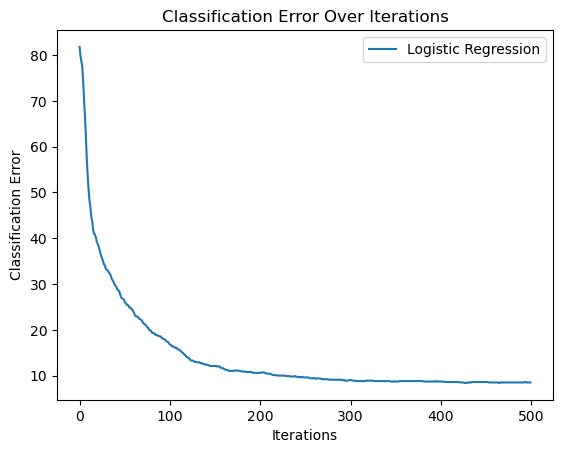

In [5]:
# Initializing parameters
eta = 0.05
count = 0

# Initializing weights
weights_logistic = np.random.normal(0, 1, size=3)
# You can store the sequence of weights of the logistic model in this list, each entry is a set of 3 weights
list_weights_logistic = list()
# You can store the sequence of percentage of incorrect classification in this list, each entry is a percentage
list_error_logistic = list()
# You can store the sequence of negative log likelihood (NLL) in this list, each entry is a value of the NLL
list_likelihood_logistic = list()

while count < 500:
    
    # Compute nll, gradient and error
    nll = negative_log_likelihood_logistic(weights_logistic, df)
    error_rate = error(weights_logistic, df)  # Calculate error
    gradient = gradient_NLL_logistic(weights_logistic, df)

    # Update weight using logistic regression
    weights_logistic = weights_logistic - eta * gradient
    
    # Store the values for plotting
    list_error_logistic.append(error_rate)  # Append error_rate, not error
    list_weights_logistic.append(weights_logistic)
    list_likelihood_logistic.append(nll)

    count += 1


# Plot the error over iterations
plt.plot(list_error_logistic)
plt.title('Classification Error Over Iterations')
plt.xlabel('Iterations')
plt.ylabel('Classification Error')
plt.legend(['Logistic Regression'])

send(plt, 8)


**4) For the last iteration, plot the decision boundary and the observations. You just have to run the cell below.**

The classification error is equal to 8.5 %


<Response [400]>

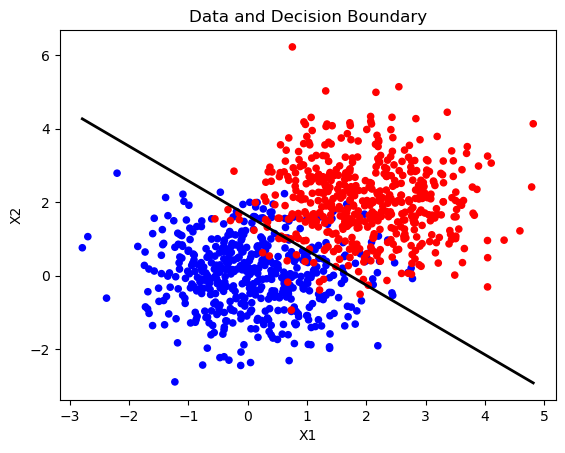

In [6]:
def boundary_equation(weights, dataset):
    """
    Calculate the decision boundary equation based on the weights.

    Parameters:
    - weights: Vector of weights.
    - dataset: Pandas DataFrame containing the dataset with columns "X1", "X2", and "Y".

    Returns:
    - x: X values for the decision boundary.
    - z: Corresponding Y values for the decision boundary.
    """
    X1min, X1max = (min(dataset["X1"]), max(dataset["X1"]))
    X2min, X2max = (min(dataset["X2"]), max(dataset["X2"]))
    if weights[1] != 0:
        x = np.array([X1min, X1max])
        z = (-weights[2] - weights[0] * x) / weights[1]
    else:
        x = np.array([-weights[2] / weights[0], -weights[2] / weights[0]])
        z = np.array([X2min, X2max])
    return x, z

def plot_data_and_boundary(weights, dataset):
    """
    Plot the dataset and the decision boundary.

    Parameters:
    - weights: Vector of weights.
    - dataset: Pandas DataFrame containing the dataset with columns "X1", "X2", and "Y".
    """
    colors = np.where(df["Y"] == 1, 'red', 'blue')
    df.plot.scatter("X1", "X2", c=colors)
    plt.plot(boundary_equation(weights, dataset)[0], boundary_equation(weights, dataset)[1], 'k-', lw=2)
    plt.title('Data and Decision Boundary')
    plt.xlabel('X1')
    plt.ylabel('X2')

plot_data_and_boundary(weights_logistic, df)
print(f"The classification error is equal to {round(error(weights_logistic, df),4)} %")
send(plt, 9)
send(np.array(error(weights_logistic, df)), 10)


#### 2.1.3 - Animation

In [7]:
####### Note: You need to install ffmpeg. #######
## On your computer.
# On Linux:
# sudo apt-get install ffmpeg
# On MacOS:
#pip install ffmpeg

### On Google Colab.
!pip install ffmpeg

In [8]:
# Additional imports for animation and FFMpegWriter
from matplotlib import lines
from matplotlib.animation import FFMpegWriter
import ffmpeg


Move the implementation into a function called `animate(t)` where `t` is the epoch. In this function you should also update the plotting code using `set_data` and `contourf` (or `pcolormesh`) where appropriate. You may find [several examples/tutorials](https://jakevdp.github.io/blog/2012/08/18/matplotlib-animation-tutorial/) on how to do this, if you are not familiar with these functions. Also, include a function called `init()` where you set up the plot.

**5) Produce a mp4 video using the following code.**

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'

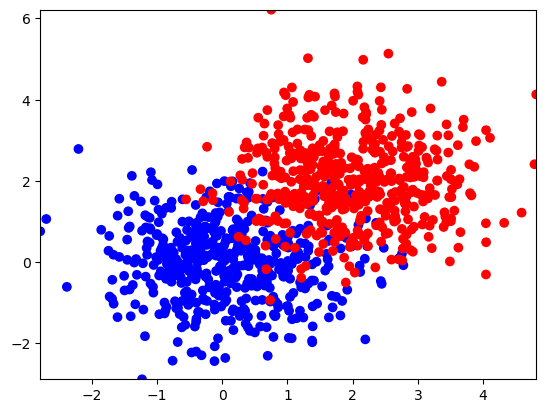

In [9]:
def create_animation(list_weights, dataset, filename):
    """
    Create an animation to visualize the decision boundary evolution over iterations.

    Parameters:
    - list_weights: List of weight vectors representing the evolution of the model.
    - dataset: Pandas DataFrame containing the dataset with columns "X1", "X2", and "Y".
    - filename: Name of the file to save the animation (without extension).
    """
    X1min, X1max = (min(dataset["X1"]), max(dataset["X1"]))
    X2min, X2max = (min(dataset["X2"]), max(dataset["X2"]))
    colors = np.where(dataset["Y"] == 1, 'red', 'blue')

    # First set up the figure, the axis, and the plot element we want to animate
    fig = plt.figure()
    ax = plt.axes(xlim=(X1min, X1max), ylim=(X2min, X2max))
    scat = plt.scatter(dataset["X1"], dataset["X2"], c=colors)
    line, = ax.plot([], [], 'k-', lw=2)

    # Initialization function: plot the background of each frame
    def init():
        line.set_data([], [])
        return line,

    # Animation function. This is called sequentially
    def animate(i):
        line.set_data(boundary_equation(list_weights[i], dataset)[0],
                      boundary_equation(list_weights[i], dataset)[1])
        return line,

    # Call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=len(list_weights), interval=50, blit=True)

    # Save the animation as an mp4 using FFMpegWriter
    final_filename = filename + ".mp4"
    FFwriter = animation.FFMpegWriter(fps=2)
    anim.save(final_filename, writer=FFwriter)

    plt.show()
    return anim

create_animation(list_weights_logistic, df, "nn_nohiddenlayer_nonlinearly_separable_dataset")


<a id='Perceptron'></a>


### 2.2 - Perceptron algorithm

**6) Implement the perceptron algorithm as seen in class. Start with the weights $(1,1,-8)$. Stop after $50000$ iterations. As for the neural network, produce a .mp4 video showing the evolution of the decision boundary.**

<Response [400]>

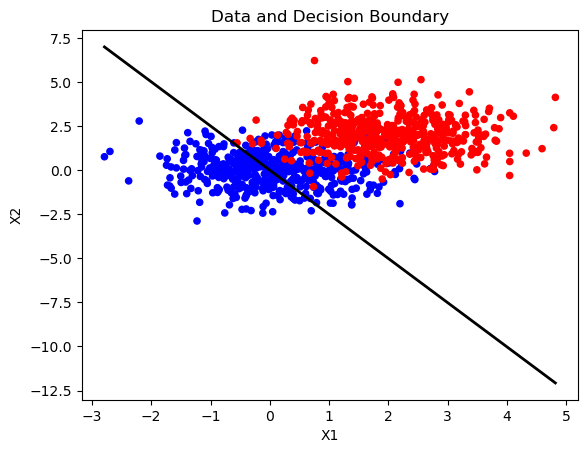

In [10]:
weights_perceptron = [1, 1, -8]
y = df.iloc[:, -1]
X = df.drop(df.columns[-1], axis=1)
Xtilde = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

# You can store the sequence of weights of the perceptron in this list, each entry is a set of 3 weights
list_weights_perceptron = list()
# Initialization for this list
list_weights_perceptron.append(weights_perceptron)

# You can store the sequence of percentage of incorrect classification in this list, each entry is a percentage
list_error_perceptron = list()
list_error_perceptron.append(error(weights_perceptron, df))

# Remembering the iteration number
iteration = 0
list_iteration = list()

# Number of updates: number of times where weights are actually updated
nb_update = 0

while iteration < df.shape[0] * 50:     #iterate over the dataset multiple times (epochs) to ensure convergence.

    i = iteration % df.shape[0]
    if y[i]*np.dot(weights_perceptron,Xtilde[i,:]) < 0:
        weights_perceptron += Xtilde[i,:]*y[i]
        nb_update +=1
  
    list_error_perceptron.append(error(weights_perceptron, df))
    list_weights_perceptron.append(weights_perceptron)
    list_iteration.append(iteration)


    iteration += 1
    

plot_data_and_boundary(list_weights_perceptron[50000], df)
send(plt, 11)


# When data is not linearly separable, perceptron doesn' work

<a id='Logistic_regression'></a>


### 2.3 - Logistic regression

**7) Using the package scikit-learn, compute the weights given by the logistic regression. Plot the decision boundary and the observations.**

[[1.98379786 2.18256941]]
[-4.22467763]
[ 1.98379786  2.18256941 -4.22467763]


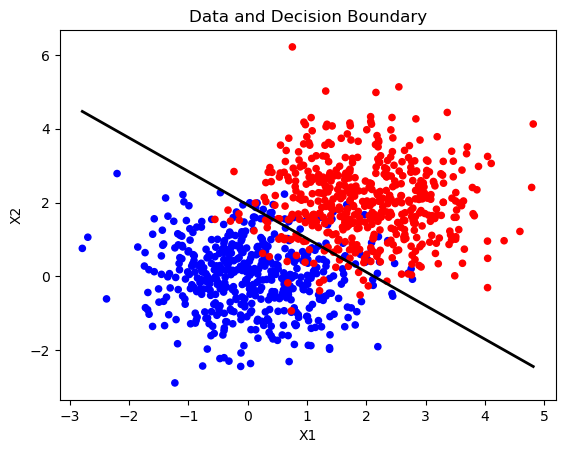

In [12]:
from sklearn.linear_model import LogisticRegression

dataset = df
y = df.iloc[:, -1]
X = dataset.drop(df.columns[-1], axis=1)


logistic_model = LogisticRegression()
logistic_model.fit(X,y)
# Pas besoinde mettre l'intercept, scikitlearn le fait


# Concatenate weights and intercept
weights_loistic_scikit = np.concatenate([logistic_model.coef_[0], logistic_model.intercept_])

# Plot the data and the decision boundary
# Ensure your plot_data_and_boundary function can handle this structure
plot_data_and_boundary(weights_loistic_scikit, df)

send(weights_loistic_scikit, 12)
print(logistic_model.coef_)
print(logistic_model.intercept_)
print(weights_loistic_scikit)


For a logistic regression model with the equation logit(p)=β0+β1​x1+β2​x2+…, where p is the probability of the dependent variable equaling a 'success' case (often coded as 1), these coefficients would correspond to 
β1=1.98379786 and β2= 2.18256941

<a id='Another_data_set'></a>

### 2.4 - Linearly separable data set

**8) Use the function 'create_dataset' defined in the second cell to generate a linearly separable data set and run again the neural network, the perceptron implemented above (with mp4 videos) and the logistic regression.**

<Response [400]>

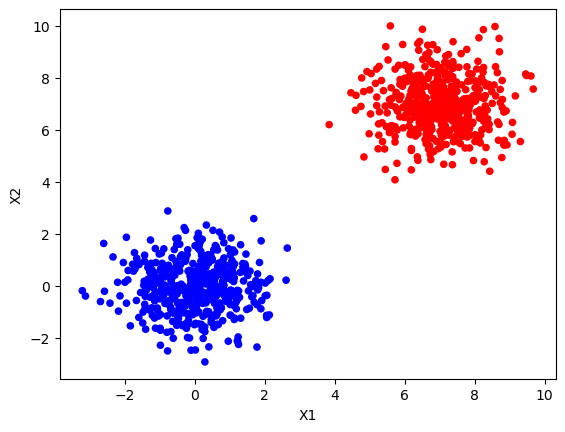

In [13]:
# Defining new means and covariance matrices
mu0 = [0, 0]
mu1 = [7, 7]
Sigma0 = np.array([[1, 0], [0, 1]])
Sigma1 = np.array([[1, 0], [0, 1]])

# Create a data set and plot it
df = create_dataset(nb_datapoints=1000, prop_class=0.5, Sigma0=Sigma0, Sigma1=Sigma1, mu0=mu0, mu1=mu1)
colors = np.where(df["Y"] == 1, 'red', 'blue')
df.plot.scatter("X1", "X2", c=colors)

send(plt, 13)

In [14]:
df

,X1,X2,Y
0,0.808108,0.134052,-1.0
1,-0.777152,-2.509752,-1.0
2,0.156162,0.469941,-1.0
3,0.208255,-1.686744,-1.0
4,-0.799654,-1.793591,-1.0
...,...,...,...
995,5.332490,7.887388,1.0
996,5.720729,5.521958,1.0
997,7.475232,7.830515,1.0
998,5.267999,8.429372,1.0


<Response [400]>

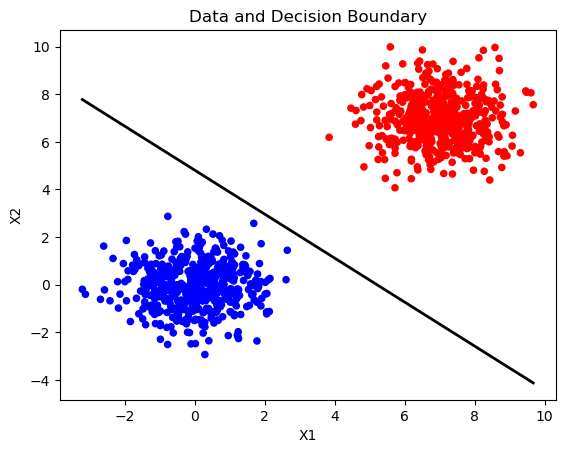

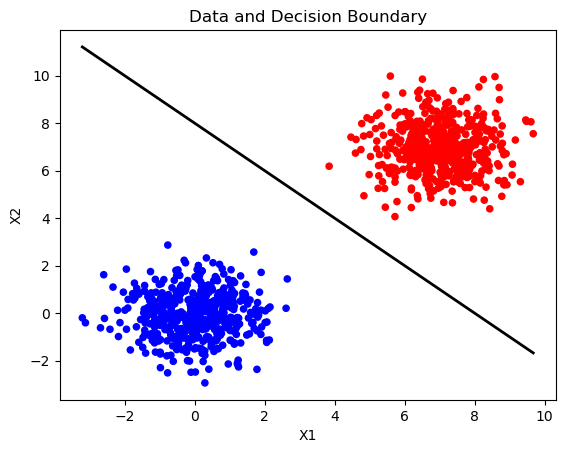

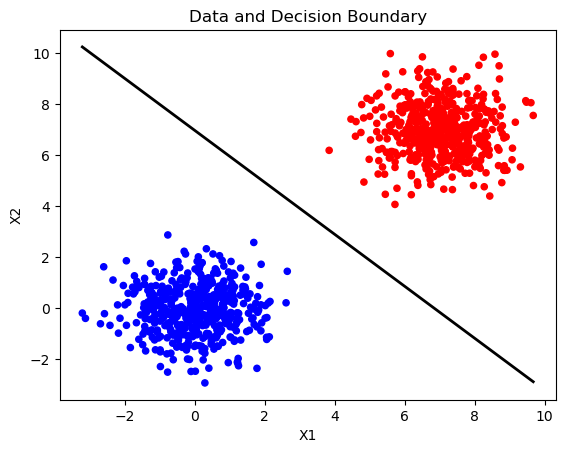

In [15]:
# 1 - Logistic Regression (by hand)
y = df.iloc[:, -1]
X = dataset.drop(df.columns[-1], axis=1)
Xtilde = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)



# Initializing parameters
eta = 0.05
count = 0

# Initializing weights
weights_logistic = np.random.normal(0, 1, size=3)
# You can store the sequence of weights of the logistic model in this list, each entry is a set of 3 weights
list_weights_logistic = list()
# You can store the sequence of percentage of incorrect classification in this list, each entry is a percentage
list_error_logistic = list()
# You can store the sequence of negative log likelihood (NLL) in this list, each entry is a value of the NLL
list_likelihood_logistic = list()

while count < 900:
    
    # Compute nll, gradient and error
    nll = negative_log_likelihood_logistic(weights_logistic, df)
    error_rate = error(weights_logistic, df)  # Calculate error
    gradient = gradient_NLL_logistic(weights_logistic, df)

    # Update weight using logistic regression
    weights_logistic = weights_logistic - eta * gradient
    
    # Store the values for plotting
    list_error_logistic.append(error_rate)  # Append error_rate, not error
    list_weights_logistic.append(weights_logistic)
    list_likelihood_logistic.append(nll)

    count += 1



plot_data_and_boundary(list_weights_logistic[-1], df)


#####################

# 2 - Perceptron

#####################


weights_perceptron = [1, 1, -8]
y = df.iloc[:, -1]
X = df.drop(df.columns[-1], axis=1)
Xtilde = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)

# You can store the sequence of weights of the perceptron in this list, each entry is a set of 3 weights
list_weights_perceptron = list()
# Initialization for this list
list_weights_perceptron.append(weights_perceptron)

# You can store the sequence of percentage of incorrect classification in this list, each entry is a percentage
list_error_perceptron = list()
list_error_perceptron.append(error(weights_perceptron, df))

# Remembering the iteration number
iteration = 0
list_iteration = list()

# Number of updates: number of times where weights are actually updated
nb_update = 0

while iteration < df.shape[0] * 50:

    i = iteration % df.shape[0]
    if y[i]*np.dot(weights_perceptron,Xtilde[i,:]) < 0:
        weights_perceptron += Xtilde[i,:]*y[i]
        nb_update +=1
  
    list_error_perceptron.append(error(weights_perceptron, df))
    list_weights_perceptron.append(weights_perceptron)
    list_iteration.append(iteration)


    iteration += 1
    

plot_data_and_boundary(list_weights_perceptron[-1], df)

#####################

# 3 - Logistic regression (with sklearn)

#####################


dataset = df
y = dataset.iloc[:, -1]
X = dataset.drop(dataset.columns[-1], axis=1)


logistic_model = LogisticRegression()
logistic_model.fit(X,y)



# Concatenate weights and intercept
weights_loistic_scikit = np.concatenate([logistic_model.coef_[0], logistic_model.intercept_])

# Plot the data and the decision boundary
# Ensure your plot_data_and_boundary function can handle this structure
plot_data_and_boundary(weights_loistic_scikit, dataset)



#####################

send(plt, 14)
send(np.array(list_error_logistic), 15)
send(np.array(list_error_perceptron), 16)
send(np.array(nb_update), 17)



**9) What are the main similarities/differences between the three algorithms?**

**The only difference between the neural network without hidden layer and the logistic regression is the optimisation procedure (Stochastic Gradient Descent for the neural network, L-BGFS i.e. Limited Memory Broyden-Fletcher-Goldfarb-Shanno a second order optimisation algorithm). The statistical model is the same. There is no statistical model behind the perceptron algorithm and the optimisation algorithm can be seen as stochastic gradient descent.

**The perceptron algorithm only converges if the data is linearly separable. When this is the case, it converges faster than the implemented neural network.** This is mainly due to the step size $\eta$, which is larger for the perceptron (=1). Note also that the weights for logistic regression do not necessarily converge for a linearly separable data set: there is an infinite number of hyperplanes that separate the data well (up to a normalising constant).

If the data set is not linearly separable, the perceptron will not converge.

**10) Since Gaussian data were generated, could we determine the best decision boundary? Do you know another algorithm,  particularly useful in this case to approximate the best decision boundary.**

If the data are Gaussian, the expression of the best decision function can be determined analytically. **Linear discriminant analysis** is a model/package that approximates the true coefficient of the decision boundary by its empirical counterpart.  

<a id='More_complicated_nn'></a>
## 3 - A more complicated neural network



**Use the command below to create and plot a new data set.** y is is {0,1}

<Response [500]>

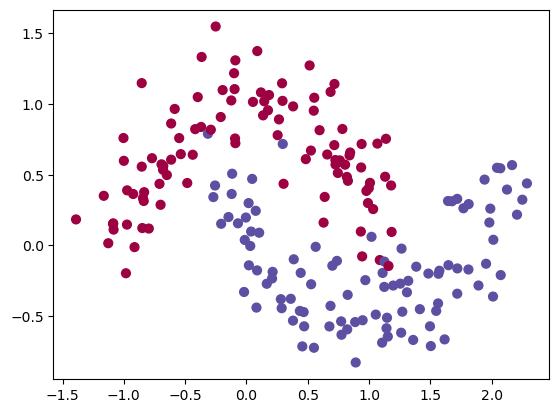

In [16]:
import sklearn
from sklearn import datasets

X, y = sklearn.datasets.make_moons(200, noise=0.20)
plt.scatter(X[:,0], X[:,1], s=40, c=y, cmap=plt.cm.Spectral)

send(plt, 18)

In [17]:
X,y

(array([[-0.12389569,  1.0256958 ],
        [-0.00469943,  0.19750537],
        [ 0.45563094, -0.71390413],
        [-0.91311764, -0.01174585],
        [-0.79645568,  0.11973072],
        [-0.19426965,  1.09925807],
        [ 0.01751654,  0.29963949],
        [ 0.48423984,  0.6105535 ],
        [ 1.08751868, -0.10311502],
        [ 1.71899661,  0.3296292 ],
        [-0.54864918,  0.75943647],
        [ 0.13562213,  0.92020688],
        [ 1.01991191,  0.06121993],
        [ 0.89113107, -0.82763492],
        [-0.77050697,  0.61723059],
        [ 0.94778269, -0.52885937],
        [ 0.54894181,  0.95327267],
        [ 1.67669593,  0.31268205],
        [-0.09042181,  0.72349968],
        [-0.3973702 ,  1.04953906],
        [-1.08833808,  0.15213684],
        [ 0.62904074,  0.16163878],
        [ 0.08830939,  1.37503957],
        [ 2.12503835,  0.39531377],
        [ 0.84079177,  0.63733854],
        [-0.68052614,  0.5351289 ],
        [-0.84954274,  0.12322742],
        [ 1.48394953, -0.198

We want to build a network with one hidden layer. The number of neurons in this network will be a variable called nn_hdim.  Let us define the following variables.

In [22]:
num_examples = len(X) # training set size
nn_input_dim = 2 # input layer dimensionality, nb de feature
nn_output_dim = 2 # output layer dimensionality

# Gradient descent parameters
epsilon = 0.015 # learning rate for gradient descent
reg_lambda = 0 # regularization strength for a L2 penalization over the weights (but not over the bias)

A network is defined by its parameters. We will thus define a dictionnary to describe a network, this dictionnary being composed of four elements named 'W1','b1','W2','b2'. We use tangent as activation function, the softmax as output function and the negative log likelihood as the loss function.



The equations defining the network are

\begin{align*}
z_1 & = x W_1 + b1\\
a_1 & = \tanh(z_1) \\
z_2 & = a_1 W_2 + b_2 \\
a_2 & = \hat{y} = \textrm{softmax}(z_2)
\end{align*}

where $z_1, x, b_1, a_1, b_2, z_2, a_2$ are arrays (and not vectors!). Letting $ \hat{y}$ be the $(1,2)$ array containing the predicted probabilities for each class as above, and $y_{\textrm{hot encoding}}$ being the one-hot encoding of $y$ (the vector containing zeros except in the $y$ position that contains $1$), the negative log loss is given by
\begin{align*}
\ell(y,\hat{y}) & = - y \log(\hat{y}_1) - (1- y) \log(\hat{y}_0)\\
& = - y_{\textrm{hot encoding}} \odot \log(\hat{y}).
\end{align*}

**11) Now, create two functions, the first one `calculate_loss(model, X, y)` to compute the loss of a model on the entire data set (composed of the input matrix X and the output vector y) and the second one `predict(model,x)` to predict the output of a model for a new observation `x`.**

In [23]:
def calculate_loss(model, X, y, reg_lambda):
    """
    Calculate the loss for the neural network model.

    Parameters:
    - model (dict): Dictionary containing the model parameters (W1, b1, W2, b2).
    - X (numpy.ndarray): Input features.
    - y (numpy.ndarray): True labels.
    - reg_lambda (float): Regularization parameter.

    Returns:
    - float: Loss value.
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation to calculate predictions

    z1 = np.dot(X,W1) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
    # each column in probs corresponds to the probability of a particular class col1 is for the label1 etc. 
    
    
    
    # Calculating the cross antropy loss
    correct_logprobs = -np.log(probs[range(len(y)), y])
    data_loss = np.sum(correct_logprobs)
    
    # Add regularization term to the loss
    data_loss += reg_lambda / 2 * (
        np.sum(np.square(W1)) + np.sum(np.square(W2)))  #TO DO OPERAND

    return 1. / X.shape[0] * data_loss


send(calculate_loss, 19)


def predict(model, x):
    """
    Predict the output for a given input using the neural network model.

    Parameters:
    - model (dict): Dictionary containing the model parameters (W1, b1, W2, b2).
    - x (numpy.ndarray): Input data for prediction.

    Returns:
    - int: Predicted class label (0 or 1).
    """
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # Forward propagation
    z1 = np.dot(x,W1) + b1
    a1 = np.tanh(z1)
    z2 = np.dot(a1,W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 
    
    return np.argmax(probs, axis=1)    
# calculates the index of the maximum value along axis=1, [0.3,0.7] will return 1

send(predict, 20)

<Response [400]>

probs = [[0.2, 0.5, 0.3], # Predicted probabilities for the first sample [0.1, 0.1, 0.8]] # Predicted probabilities for the second sample 

y = [1, 2] # True labels: first sample belongs to class 1, second to class 2


Now, let's compute correct_logprobs:

range(len(y)) creates an array [0, 1].
probs[range(len(y)), y] will select probs[0, 1] and probs[1, 2]. These are the predicted probabilities of the true classes for each sample. So it selects 0.5 (probability of class 1 for the first sample) and 0.8 (probability of class 2 for the second sample).

Finally, -np.log([0.5, 0.8]) computes the negative log of these probabilities, resulting in [0.6931, 0.2231].


**Interpretation:**
The cross-entropy loss for each sample is the negative log of the probability assigned to the correct class. A higher probability (close to 1) given to the correct class will result in a lower loss, and a lower probability (close to 0) will result in a higher loss.
The total cross-entropy loss would be the average of these individual losses, which in this case is (0.6931 + 0.2231) / 2.

La fonction de perte d'entropie croisée capture l'idée que la perte devrait être plus élevée lorsque le modèle attribue une faible probabilité à la classe correcte, et plus basse lorsque le modèle est confiant et correct au sujet de la classe.


Dans un format one-hot, la multiplication par y équivaut à sélectionner la probabilité correspondante à la classe correcte, car toutes les autres probabilités sont multipliées par 0 et donc ignorées.

**12) Derive the calculations that are necessary to update the weights.**

By definition,
\begin{align*}
\ell(y,\hat{y}) & = - \sum_{j=1}^2 y_i \log(\hat{y}_i) \\
& = - \sum_{j=1}^2 y_i (z_2)_j + \log(\sum_{j=1}^2 e^{(z_2)_j}).
\end{align*}
Consequently,
\begin{align*}
\frac{\partial \ell }{\partial (z_2)_j} = \hat{y}_j - y_j,
\end{align*}
and
\begin{align*}
\frac{\partial \ell }{\partial z_2} = \hat{y} - y, \quad \frac{\partial \ell }{\partial b_2} = \hat{y} - y.
\end{align*}
Finally,
\begin{align*}
\frac{\partial \ell }{\partial (W_2)_{ik}} & = \sum_j \frac{\partial \ell }{\partial (z_2)_j} \frac{\partial (z_2)_j}{\partial (W_2)_{ik}}\\
& = (\hat{y}_k - y_k) (a_1)_i,
\end{align*}
that is
\begin{align*}
\frac{\partial \ell }{\partial W_2} & = a_1^T (\hat{y} - y).
\end{align*}
Recalling that $\tanh ' = 1 - \tanh^2$, the same derivations lead to
\begin{align*}
\frac{\partial \ell }{\partial b_1} = (1 - \tanh^2(z_1)) \circ (\hat{y} - y) W_2^T , \quad \textrm{and} \quad \frac{\partial \ell }{\partial W_1} & = x^T ((1 - \tanh^2(z_1)) \circ (\hat{y} - y) W_2^T).
\end{align*}

**13) Write a function `build_model(nn_hdim, num_passes=20000, print_loss=False)` to build the network.**

# Explain Delta3

In [24]:
def build_model(nn_hdim, num_passes=20000, print_loss=False):
    """
    Build a neural network model.

    Parameters:
    - nn_hdim (int): Number of nodes in the hidden layer.
    - num_passes (int): Number of passes through the training data for gradient descent.
    - print_loss (bool): If True, print the loss every 1000 iterations.

    Returns:
    - dict: Model parameters (W1, b1, W2, b2).
    """

    # Initialize the parameters to random values. We need to learn these.
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # This is what we return at the end
    model = {}
    
    
    # Gradient descent. For each batch...
    for i in range(0, num_passes):

        # Forward propagation
        z1 = np.dot(X,W1) + b1
        a1 = np.tanh(z1)
        z2 = np.dot(a1,W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True) 


        # Backpropagation
        delta3 = probs
        delta3[range(num_examples), y] -= 1   
        # y est un tableau contenant les étiquettes réelles pour chaque échantillon

  
        dW2 = np.dot(a1.T, delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = np.dot(delta3, W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # Add regularization terms (b1 and b2 don't have regularization terms)
        dW2 += reg_lambda * W2
        dW1 += reg_lambda * W1

        # Gradient descent parameter update
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2
        

        # Assign new parameters to the model
        model = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        # Optionally print the loss.
        # This is expensive because it uses the whole dataset, so we don't want to do it too often.
        #if print_loss and i % 1000 == 0:
        #    print(f"Loss after iteration {i}: {calculate_loss(model, X, y, reg_lambda)}")

    return model

send(build_model, 21)

<Response [400]>

**14) Test the network performance with different numbers of neurons in the hidden layer. Plot the decision function. You can use the function below.**

In [25]:
def plot_decision_boundary(pred_func):
    """
    Plot the decision boundary.

    Parameters:
    - pred_func: Function that predicts the class.
    """
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole gid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


<Response [400]>

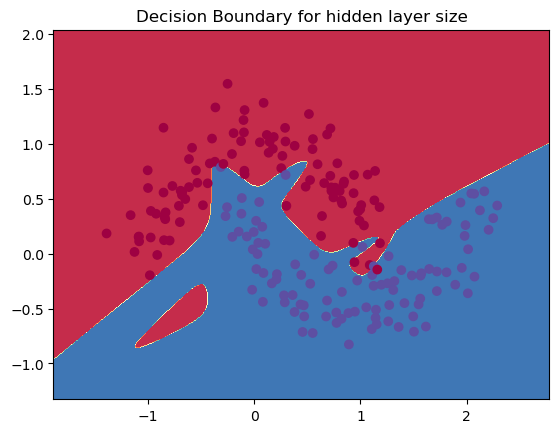

In [26]:
model = build_model(15, print_loss=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(model, x))
plt.title('Decision Boundary for hidden layer size')
send(plt, 22)


<a id='Bonus'></a>

## 4 -  Bonus: Experiments

You can try to improve the network performance by adding the following mechanisms:
- Different learning rates; try decaying the learning rate
- Different initialization of $\mathbf{w}$
- Activation function (e.g., try a rectified linear units)
- Plot the error rate also on some test data from the same distribution (generate some more)
- Calculate the gradient on a batch of 10 instances at a time (instead of just one)